In [2]:
sc

''

In [3]:
import findspark

In [4]:
findspark.init("/Users/akashsoni/spark")

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from operator import add
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from bokeh.plotting import figure, show, output_notebook
import pandas as pd
import matplotlib.pyplot as plt
output_notebook() # for jupyter notebook only.



Loading BokehJS ...

In [6]:
spark = SparkSession \
    .builder \
    .appName("Python Spark ML example") \
    .getOrCreate()
	

In [7]:
ad_data= spark\
.read\
.option("inferSchema", "true")\
.option("header", "true")\
.csv("/Users/akashsoni/adult5.csv")
ad_data.createOrReplaceTempView("adult")
dataset = spark.table("adult")
cols = dataset.columns

In [8]:
ad_data.show()

+---+-----------------+------+-----------+-------------+----------------+-------+--------------+------+
|age|        workclass|fnlwgt|  education|education_num|      occupation|    sex|hours_per_week|income|
+---+-----------------+------+-----------+-------------+----------------+-------+--------------+------+
| 39|        State-gov| 77516|  Bachelors|           13|    Adm-clerical|   Male|            40| <=50K|
| 52| Self-emp-not-inc|209642|    HS-grad|            9| Exec-managerial|   Male|            45|  >50K|
| 31|          Private| 45781|    Masters|           14|  Prof-specialty| Female|            50|  >50K|
| 23|          Private|122272|  Bachelors|           13|    Adm-clerical| Female|            30| <=50K|
| 32|          Private|205019| Assoc-acdm|           12|           Sales|   Male|            50| <=50K|
+---+-----------------+------+-----------+-------------+----------------+-------+--------------+------+



In [9]:
categoricalColumns = ["workclass", "occupation"]

In [10]:
stages = []
for categoricalCol in categoricalColumns:
	stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#.fit(ad_data)
	#df_numeric = stringIndexer.transform(ad_data)
	#df_numeric.repartition(1).repartition(1).write.csv('indexer')
	#print df_numeric.select('workclass','workclassIndex').show(5)
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
	encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
	#print encoder.outputCol
	stages += [stringIndexer, encoder]

In [11]:
stages

[StringIndexer_451d8637a605104e0932,
 OneHotEncoder_4a1abd52c96ca898cb30,
 StringIndexer_455cb522555327609e5e,
 OneHotEncoder_43e78c428aaef18cb680]

In [12]:
label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")

In [13]:
stages += [label_stringIdx]

In [14]:
numericCols = ["age", "hours_per_week"]

In [15]:
assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) 

In [16]:
assemblerInputs

In [17]:
assemblerInputs=list(assemblerInputs) + numericCols

In [18]:
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [19]:
stages += [assembler]

In [20]:
pipeline = Pipeline(stages=stages)

In [21]:
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)

In [38]:
dataset.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- income: string (nullable = true)



In [39]:
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)

In [40]:
dataset.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- income: string (nullable = true)



In [41]:
dataset

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: int, education: string, education_num: int, occupation: string, sex: string, hours_per_week: int, income: string]

In [65]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
#trainnig data

In [66]:
trainingData.show()

+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+
|label|            features|age| workclass|fnlwgt|  education|education_num|     occupation|    sex|hours_per_week|income|
+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+
|  0.0|[0.0,1.0,1.0,0.0,...| 39| State-gov| 77516|  Bachelors|           13|   Adm-clerical|   Male|            40| <=50K|
|  0.0|[1.0,0.0,0.0,1.0,...| 32|   Private|205019| Assoc-acdm|           12|          Sales|   Male|            50| <=50K|
|  0.0|[1.0,0.0,1.0,0.0,...| 23|   Private|122272|  Bachelors|           13|   Adm-clerical| Female|            30| <=50K|
|  1.0|(7,[0,5,6],[1.0,3...| 31|   Private| 45781|    Masters|           14| Prof-specialty| Female|            50|  >50K|
+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+



In [44]:
testData.show()

+-----+--------------------+---+-----------------+------+---------+-------------+----------------+-----+--------------+------+
|label|            features|age|        workclass|fnlwgt|education|education_num|      occupation|  sex|hours_per_week|income|
+-----+--------------------+---+-----------------+------+---------+-------------+----------------+-----+--------------+------+
|  1.0|(7,[4,5,6],[1.0,5...| 52| Self-emp-not-inc|209642|  HS-grad|            9| Exec-managerial| Male|            45|  >50K|
+-----+--------------------+---+-----------------+------+---------+-------------+----------------+-----+--------------+------+



In [56]:
testData.select('features')

DataFrame[features: vector]

In [27]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

In [28]:
lrModel = lr.fit(trainingData)

In [29]:
predictions = lrModel.transform(testData)

predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [30]:
trainingData.show()

+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+
|label|            features|age| workclass|fnlwgt|  education|education_num|     occupation|    sex|hours_per_week|income|
+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+
|  0.0|[0.0,1.0,1.0,0.0,...| 39| State-gov| 77516|  Bachelors|           13|   Adm-clerical|   Male|            40| <=50K|
|  0.0|[1.0,0.0,0.0,1.0,...| 32|   Private|205019| Assoc-acdm|           12|          Sales|   Male|            50| <=50K|
|  0.0|[1.0,0.0,1.0,0.0,...| 23|   Private|122272|  Bachelors|           13|   Adm-clerical| Female|            30| <=50K|
|  1.0|(7,[0,5,6],[1.0,3...| 31|   Private| 45781|    Masters|           14| Prof-specialty| Female|            50|  >50K|
+-----+--------------------+---+----------+------+-----------+-------------+---------------+-------+--------------+------+



In [31]:
selected = predictions.select("label", "prediction", "probability", "income", "occupation","rawPrediction")
selected.printSchema()

root
 |-- label: double (nullable = true)
 |-- prediction: double (nullable = true)
 |-- probability: vector (nullable = true)
 |-- income: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)



In [78]:
x=trainingData.select("features")

In [77]:
y=trainingData.select("label")

In [84]:
x.show(100)

+--------------------+
|            features|
+--------------------+
|[0.0,1.0,1.0,0.0,...|
|[1.0,0.0,0.0,1.0,...|
|[1.0,0.0,1.0,0.0,...|
|(7,[0,5,6],[1.0,3...|
+--------------------+



In [85]:
y.show(100)

+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  1.0|
+-----+



In [81]:
plt.scatter(x,y,color='green')

ValueError: setting an array element with a sequence.

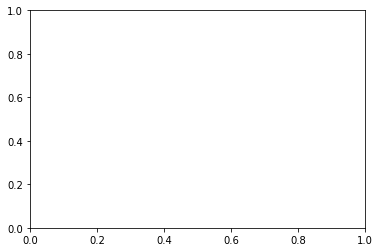

In [80]:
plt.show()